Metody numeryczne Projekt 1
autor: Stanisław Smykowski
nr indeksu: 184787

Cel projektu:
Celem projektu jest zapoznanie się z jednym z podstawowych wskaźników przeznaczonych do analizy giełdowej, czyli MACD. Dodatkowo, 
implementując go, student powinien zapoznać się z metodami wykonywania obliczeń numerycznych w wybranym przez niego środowisku: Python lub c++. W końcowej części powinna znaleźć się analiza przydatności danego wskaźnika.

Pozyskanie danych:
W pierwszej kolejności musiałem wybrać dane, na których będę pracował w tym projekcie. Ze względów sentymentalnych prawie od razu wiedziałem, że chciałbym, aby była to cena złota. Niestety, jak się okaże później, ten wybór wiązał się z pewnymi trudnościami. W internecie znalazłem stronę, z której pobrałem plik csv z historycznymi danymi z ostatnich trzech lat. Jest to cena w dolarach za jedną uncję. Poniżej link do strony:
https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical

Wstępna obróbka danych:
Następnym w kolejności krokiem było wczytanie i obrobienie danych.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('historicalData.csv')
dataReversed = df['Close/Last']
data = dataReversed[::-1].reset_index(drop=True)
x = np.arange(0, 1000)

Po wczytaniu pliku csv za pomocą funkcji z biblioteki pandas wybrałem interesującą mnie kolumnę, w tym przypadku była to cena zamknięcia. Później musiałem odwrócić kolejność rekordów, aby daty ułożyły się rosnąco. Przygotowałem też wektor indeksów od 1 do 1000, który przyda się przy rysowaniu wykresów.

Implementacja MACD:

In [27]:
def computingEma(data, period):
    result = pd.Series(index=range(len(data)), dtype='float64')
    alpha = 2 / (period + 1)
    for n in range(period, len(data)):
        tmpSum = 0
        tmpDiv = 0
        for i in range(0, period + 1):
            tmpSum += data[n - i] * pow((1 - alpha), i)
            tmpDiv += pow((1 - alpha), i)
        result.iloc[n] = tmpSum / tmpDiv
    return result


def computeMacd(data):
    ema12 = computingEma(data, 12)
    ema26 = computingEma(data, 26)
    macd = pd.Series(index=range(len(data)), dtype='float64')
    for i in range(0, len(data) - 1):
        macd.iloc[i] = ema12[i] - ema26[i]
    signal = computingEma(macd, 9)
    return macd, signal

macd = computeMacd(data)[0]
signal = computeMacd(data)[1]

Funkcja computeEma liczy wykładniczą średnią kroczącą z podanych dany przy podanym okresie (period). Wykorzystałem tutaj wzór podany w instrukcji do tego projektu. Warto zaznaczyć, że w mojej implementacji w wynikowej liście wartości pod indeksami mniejszymi niż długość zadanego okresu mają nieokreśloną wartość. Gdybym tak nie zrobił, ich wartości mogłyby zaburzać działanie algorytmu symulującego. Funkcja computeMacd również wykorzystuje wzór z instrukcji i liczy wartości wskaźnika MACD dla kolejnych dni. Tutaj również zostawiam nieokreślone wartości na początku z tych samych względów. Zmienne macd i signal zawierają to, co będę później potrzebował do rysowania wykresu i wyznaczania sygnałów.

Wykresy i interpretacja:

Wykres cen złota w zależności od dnia:

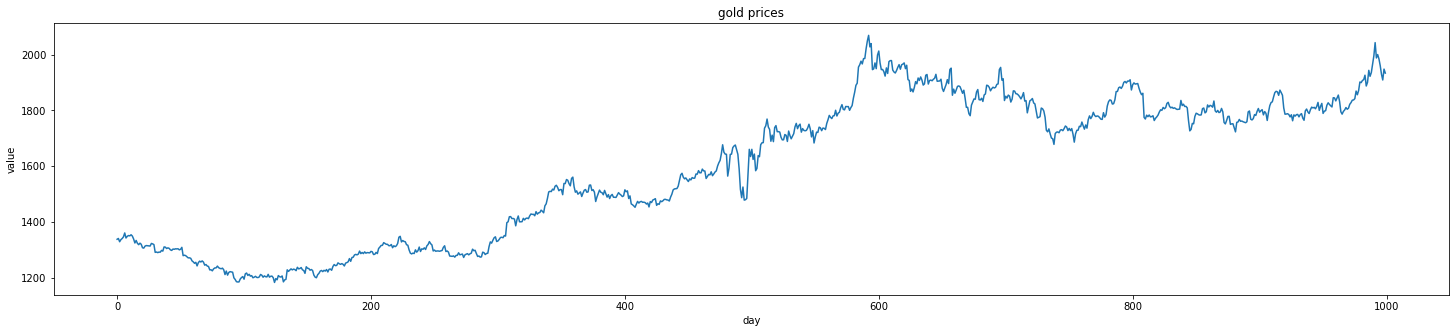

In [35]:
plt.figure(figsize = (25, 5))
plt.xlabel("day")
plt.ylabel("value")
plt.title("gold prices")
plt.plot(data)

Wykres linii signal i macd w zależności od dnia:

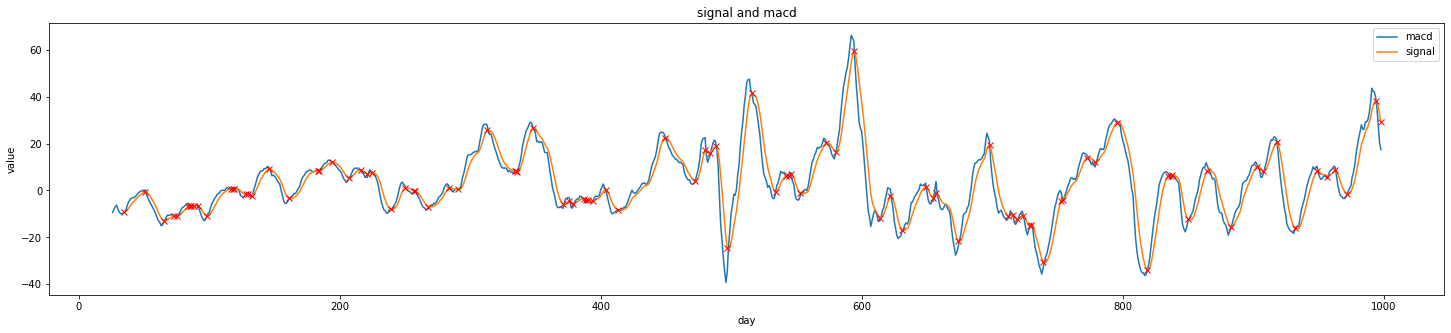

In [38]:
plt.figure(figsize = (25, 5))
plt.xlabel("day")
plt.ylabel("value")
plt.title("signal and macd")
plt.plot(x, macd, label="macd")
plt.plot(x, signal, label="signal")
plt.legend(loc="upper right")
signals = np.argwhere(np.diff(np.sign(macd - signal))).flatten()
plt.plot(x[signals], signal[signals], 'rx', label="crossing points")

Czerwonymi krzyżykami zaznaczone są przecięcia się linii signal i macd. W teorii powinny one wyznaczać momenty zakupu i sprzedaży aktywów. Są one wyznaczone za pomocą funkcji z biblioteki numpy. Jeżeli linia macd przecina signal od góry to powinno się kupować aktywa, w sytuacji odwrotnej — sprzedawać. Linia signal jest oczywiście gładsza niż macd, ponieważ przedstawia jej średnią. 

Bardziej wymown będzie wykres cen złota z zaznaczonymi punktami przecięcia wyznaczonymi jak na wykresie wyżej. Punkty te zaznaczone będą niebieskimi, pionowymi liniami.

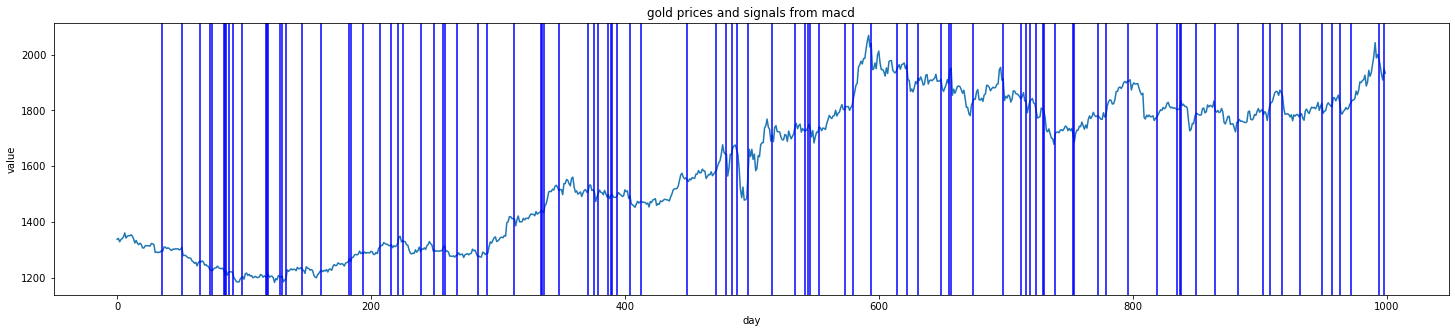

In [37]:
plt.figure(figsize = (25, 5))
plt.xlabel("day")
plt.ylabel("value")
plt.title("gold prices and signals from macd")
plt.plot(data)

for i in signals:
    if i > 34:
        plt.axvline(x=i, color='b', label='axvline - full height')

Jak, widać miejscami linie pokrywają się i trudno odczytać jest dane z wykresu. Można jednak zauważyć, że sygnały reagują na zmiany cen kilka dni po tym, jak pojawi się duża różnica. Z tego względu ta metoda powinna działać najlepiej dla długoterminowych inwestycji. Wskaźnik okazuje się jednak pomocny w analizie danych historycznych. Na jego podstawie można łatwo obserwować wzrosty i spadki cen. Chciałbym móc pokazać te wykresy w większej rozdzielczości, ale niestety nie jest to możliwe za pomocą narzędzia, którego używam. Kiedy oglądałem te wykresy w przybliżeniu mogłem zuważyć pwene zależności między sygnałami od macd i tendencjami cen złota.

Najlepszym sposobem na sprawdzenie, jak taki sposób decydowania o inwestowaniu działa będzie przeprowadzenie symulacji. Napisałem więc funkcję, która to umożliwia:

In [31]:
def simulate(inputPrices, signals, inMacd, inSignal):
    cutSignals = signals[33:]
    money = 0
    units = 1000
    startValue = 1000 * inputPrices[0]
    for i in cutSignals:
        if inMacd[i - 1] < inSignal[i - 1]:
            units += money / inputPrices[i]
            money = 0
        if inMacd[i - 1] > inSignal[i - 1]:
            money += units * inputPrices[i]
            units = 0
    endValue = units * inputPrices[999] + money
    profit = endValue / startValue
    return profit, endValue, startValue

W tej funkcji w celu ocenienia, czy dany punkt przecięcia ma być momentem kupna, czy sprzedaży porównuję wartość z macd i signal z dnia poprzedniego. Może to prowadzić do sytuacji, w której niezapadanie decyzja o akcji, gdy wartości te są do siebie zbliżone. Jednak takie momenty mogą być niebezpieczne i wynikać tylko z drobnych fluktuacji. Na początku symulacji mam do dyspozycji 1000 jednostek złota, które warte są ponad milion dolarów, czyli znaczną kwotę, ale nie powinno to mieć większego wpływu na przebieg symulacji. Funkcja oprócz zysku zwraca też początkową wartość aktywów i końcową, mają one pomóc w ocenie symulacji. Zakładam, że złoto można kupować w dowolnej ilości i nie muszę ograniczać się do jednostek. W rzeczywistości tak właśnie jest — da się kupić dowolną ilość.

Przeprowadzenie i wyniki symulacji:

In [32]:
simulationResult = simulate(data, signals, macd, signal)
print("1000 periods profit: ", simulationResult[0])
print("1000 periods final value: ", simulationResult[1])
print("1000 periods initial value: ", simulationResult[2])

1000 periods profit:  1.8637414095218392
1000 periods final value:  2492381.3869535555
1000 periods initial value:  1337300.0


Wyniki symulacji są dość zaskakujące. Zysk rzędu 86% jest nie do pomyślenia w przypadku zwykłego handlu aktywami na giełdzie. Podejrzewam, że ogromny wpływ na wzbogacenie się ma znaczący wzrost ceny złota na przestrzeni tych lat. Gdyby właściciel nie grał na giełdzie, tylko po prostu utrzymywał taką ilość aktywów, to jego wzbogacenie również byłoby znaczne. Z ekonomicznego punkt widzenia trzeba by też wziąć pod uwagę spadek wartości pieniądza.

Przeprowadziłem też symulację dla 300 dni:

In [33]:
simulationResult = simulate(data, signals[35:67], macd, signal)
print("300 periods profit: ", simulationResult[0])
print("300 periods final value: ", simulationResult[1])
print("300 periods initial value: ", simulationResult[2])

300 periods profit:  1.4461227847154714
300 periods final value:  1933900.0
300 periods initial value:  1337300.0


Jak widać, zysk nie jest tak ogromy, ale nadal bardzo znaczący. Starałem się wybrać okres, na którego początku i końcu cena złota jest porównywalna. Jednak 44% zysku to naprawdę bardzo dużo. Zaznaczam, że algorytm w trakcie działania nie wie, jakie będą ceny w dniach następnych, podejmuje decyzje tylko na podstawie MACD.

Podsumowanie i wnioski:

Dzięki temu projektowi mogłem zapoznać się z wieloma narzędziami do opracowywania danych numerycznych. Nauczyłem się podstaw analizy giełdy i wiele więcej. Jestem bardzo zadowolony z wiedzy i umiejętności, które przyswoiłem, szczególnie, z tego powodu, że nie miałem okazji używać do tej pory większości z tych rzeczy, których używać musiałem w przy tym zadani. Co do samego MACD uważam, że jest on pomocny w podstawowej analizie giełdy. Czasami, gdy fluktuacje cen są zbyt drobne, pojawia się zbyt dużo miejsc przecięcia, ale z łatwością da się ominąć ten problem. Sam nie zdecydowałbym się decydować o kupnie czy sprzedaży aktywów tylko na jego podstawie, ale wyniki symulacji są wprost zaskakujące. Biorę pod uwagę, że w kodzie jest jakiś błąd, którego nie znalazłem pomimo wielokrotnego sprawdzania poprawności jego działania.